In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!ls

sample_data


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [ ]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## WARNING, FILE "delay_clean_SVM.txt" is > 1.2 GB  --  added to gitignore

In [ ]:
# Load and parse the data file, converting it to a DataFrame
clean = spark.read.format("libsvm").load('/content/drive/MyDrive/Colab_Notebooks/delay_clean_SVM.txt')
clean.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
clean.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Number of rows in dataset
number_rows = clean.count()
number_rows

6489024

In [ ]:
clean.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|5261657|
|  1.0|1227367|
+-----+-------+



In [ ]:
# Index labels, adding metadata to the label column
# Fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol = "label", outputCol = "indexedLabel").fit(clean)

In [ ]:
# Automatically identify categorical features, and index them
# Set maxCategories so features with > 4 distinct values are treated as continuous
featureIndexer = VectorIndexer(inputCol = "features", outputCol = "indexedFeatures", maxCategories = 4).fit(clean)

In [ ]:
from pyspark.ml.feature import Normalizer

In [ ]:
normalizer = Normalizer(inputCol = "features", outputCol = "normFeatures", p = 1.0)
NormOutput = normalizer.transform(clean)

In [ ]:
# Split the data into training and test sets
(trainingData, testData) = clean.randomSplit([0.7, 0.3])

In [ ]:
trainingData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
testData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



## Oversampling performed to dataset
### https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

In [ ]:
from pyspark.sql.functions import col, explode, array, lit

In [ ]:
major_df = clean.filter(col("label") == 0)
minor_df = clean.filter(col("label") == 1)
ratio = int(major_df.count()/minor_df.count())
print("Ratio of original dataset: {}".format(ratio)+" to 1 (on time : delayed flights)")

Ratio of original dataset: 4 to 1 (on time : delayed flights)


In [ ]:
a = range(ratio)

In [ ]:
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

In [ ]:
# combine both oversampled minority rows and previous majority rows
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
combined_df.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|5261657|
|  1.0|4909468|
+-----+-------+



In [ ]:
# Split the data into training and test sets
(trainingData, testData) = combined_df.randomSplit([0.7, 0.3])

In [ ]:
trainingData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
testData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



# Gradient-boosted tree classifier (GBT)

In [ ]:
# Train a GBT model
gbt = GBTClassifier(labelCol = "indexedLabel", featuresCol = "indexedFeatures", maxIter = 30, maxDepth = 10,
                    stepSize = 1)

In [ ]:
# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages = [labelIndexer, featureIndexer, gbt])

In [ ]:
# Train model.  This also runs the indexers
import time
start_time = time.time()
model = pipeline.fit(trainingData)
print("Training Time: %s seconds" % (str(time.time() - start_time)))

Training Time: 2826.2487757205963 seconds


In [ ]:
# Make predictions
predictions = model.transform(testData)

In [ ]:
# Select example rows to display
predictions.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       1.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
+----------+------------+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol = "indexedLabel", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.672238
Test Error = 0.327762


In [ ]:
gbtModel = model.stages[2]
print(gbtModel)

GBTClassificationModel: uid = GBTClassifier_e0aa2aa57e63, numTrees=30, numClasses=2, numFeatures=153


In [ ]:
y_true = predictions.select(['indexedLabel']).collect()
y_pred = predictions.select(['prediction']).collect()

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1111369  466514]
 [ 533531  939719]]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69   1577883
         1.0       0.67      0.64      0.65   1473250

    accuracy                           0.67   3051133
   macro avg       0.67      0.67      0.67   3051133
weighted avg       0.67      0.67      0.67   3051133



In [ ]:
importanceSummary = gbtModel.featureImportances
importanceSummary

SparseVector(153, {0: 0.0764, 1: 0.0469, 2: 0.0351, 3: 0.1068, 4: 0.0281, 5: 0.0372, 6: 0.0261, 7: 0.0364, 8: 0.0338, 9: 0.0203, 10: 0.0114, 11: 0.0127, 12: 0.0204, 13: 0.0262, 14: 0.0052, 15: 0.0749, 16: 0.0089, 17: 0.006, 18: 0.0681, 19: 0.0619, 20: 0.0081, 21: 0.0158, 22: 0.0108, 23: 0.0104, 24: 0.0106, 25: 0.0075, 26: 0.0062, 27: 0.0084, 28: 0.0042, 29: 0.0028, 30: 0.0032, 31: 0.0028, 32: 0.0037, 33: 0.0035, 34: 0.004, 35: 0.0033, 36: 0.0031, 37: 0.007, 38: 0.0069, 39: 0.002, 40: 0.0003, 41: 0.0021, 42: 0.0004, 43: 0.0006, 44: 0.0013, 45: 0.0063, 46: 0.0012, 47: 0.0004, 48: 0.0046, 49: 0.0048, 50: 0.0005, 51: 0.0024, 52: 0.0028, 53: 0.002, 54: 0.0013, 55: 0.0005, 56: 0.0001, 57: 0.0, 58: 0.0002, 59: 0.0002, 60: 0.0004, 61: 0.0003, 62: 0.0002, 63: 0.0003, 64: 0.0003, 65: 0.0003, 66: 0.0007, 67: 0.0017, 68: 0.0007, 69: 0.0006, 70: 0.0035, 71: 0.0011, 72: 0.0003, 73: 0.0015, 74: 0.0009, 75: 0.0002, 76: 0.0004, 77: 0.0011, 78: 0.0004, 79: 0.0003, 80: 0.0003, 81: 0.0002, 82: 0.0008, 83:

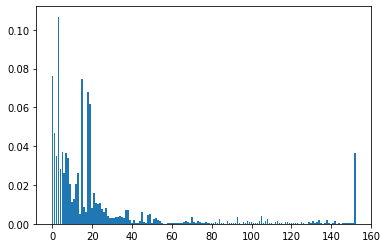

In [ ]:
from matplotlib import pyplot as plt
plt. bar(x = range (len (importanceSummary)), height = importanceSummary)
plt.show()

In [ ]:
# Saving trained model
# model_path = "./drive/" + "./MyDrive/" + "./SavedModels/" + "GBTmodel"
# model.write().overwrite().save(model_path)

# Random forest classifier (RFC)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString

In [ ]:
# Train a RandomForest model
rf = RandomForestClassifier(labelCol = "indexedLabel", featuresCol = "indexedFeatures", numTrees = 40)

In [ ]:
# Convert indexed labels back to original labels
labelConverter = IndexToString(inputCol = "prediction", outputCol = "predictedLabel",
                               labels = labelIndexer.labels)

In [ ]:
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages = [labelIndexer, featureIndexer, rf, labelConverter])

In [ ]:
# Train model.  This also runs the indexers
import time
start_time = time.time()
model = pipeline.fit(trainingData)
print("Training Time: %s seconds" % (str(time.time() - start_time)))

Training Time: 322.0480921268463 seconds


In [ ]:
# Make predictions
predictions1 = model.transform(testData)

In [ ]:
# Select example rows to display
predictions1.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           1.0|  0.0|(153,[0,1,2,3,4,5...|
|           0.0|  0.0|(153,[0,1,2,3,4,5...|
|           1.0|  0.0|(153,[0,1,2,3,4,5...|
|           0.0|  0.0|(153,[0,1,2,3,4,5...|
|           0.0|  0.0|(153,[0,1,2,3,4,5...|
+--------------+-----+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol = "indexedLabel", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions1)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.605681
Test Error = 0.394319


In [ ]:
rfModel = model.stages[2]
print(rfModel)

RandomForestClassificationModel: uid=RandomForestClassifier_351d352000e1, numTrees=40, numClasses=2, numFeatures=153


In [ ]:
print(rfModel.featureImportances)

(153,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,31,32,33,34,35,36,37,38,39,43,44,45,47,48,49,51,52,53,54,55,59,60,64,66,67,69,70,73,76,77,82,83,85,88,89,90,93,94,95,98,104,105,108,111,112,113,118,119,122,126,131,134,138,142,146,151,152],[0.018870592327006504,0.00036564807008277915,0.0026655922906295357,0.17587199053050737,0.004608056054057199,0.0017172606893847797,0.009592176498451342,0.012677601733928338,0.00788354421067915,0.011494760423238682,0.004111352641852291,0.006348361286411917,0.0039461900942429125,0.00020281801064690475,0.1252025022928781,0.15580881602864347,0.025515321215728765,0.0032532301140272154,0.003961652971846607,0.009833446945592678,0.018868569128882764,0.11841852575958094,0.05672187292500014,0.030122988821327544,0.015986677160697047,0.003814560500161905,0.00030191642306081956,0.00035511013901578094,0.001030228332587629,0.004183033968001582,0.012327672441391734,0.03254772493721072,0.03681304358533879,0.002993378104420431,0.00978332

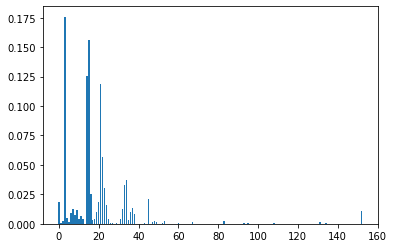

In [ ]:
from matplotlib import pyplot as plt
plt. bar(x = range (len (rfModel.featureImportances)), height = rfModel.featureImportances)
plt.show()

In [ ]:
y_true = predictions1.select(['indexedLabel']).collect()
y_pred = predictions1.select(['prediction']).collect()

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1044627  533256]
 [ 669865  803385]]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.66      0.63   1577883
         1.0       0.60      0.55      0.57   1473250

    accuracy                           0.61   3051133
   macro avg       0.61      0.60      0.60   3051133
weighted avg       0.61      0.61      0.60   3051133



In [ ]:
# Saving trained model
# model_path = "./drive/" + "./MyDrive/" + "./SavedModels/" + "RFmodel"
# model.write().overwrite().save(model_path)

# Factorization machines classifier

In [ ]:
from pyspark.ml.classification import FMClassifier
from pyspark.ml.feature import MinMaxScaler

In [ ]:
# Index labels, adding metadata to the label column
# Fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol = "label", outputCol = "indexedLabel").fit(clean)

# Scale features
featureScaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures").fit(clean) 

In [ ]:
# Split the data into training and test sets
(trainingData, testData) = clean.randomSplit([0.7, 0.3])

In [ ]:
# Train a FM model
fm = FMClassifier(labelCol = "indexedLabel", featuresCol = "scaledFeatures", stepSize = 0.01)

In [ ]:
# Create a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureScaler, fm])

In [ ]:
# Train model
start_time = time.time()
model = pipeline.fit(trainingData)
print("Training Time: %s seconds" % (str(time.time() - start_time)))

In [ ]:
# Make predictions
predictions2 = model.transform(testData)

In [ ]:
# Select example rows to display
predictions2.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
+----------+------------+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol = "indexedLabel", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions2)
print("Test set accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Test set accuracy = 0.811822
Test Error = 0.188178


In [ ]:
y_true = predictions2.select(['indexedLabel']).collect()
y_pred = predictions2.select(['prediction']).collect()

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1576218    3695]
 [ 362924    5417]]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90   1579913
         1.0       0.59      0.01      0.03    368341

    accuracy                           0.81   1948254
   macro avg       0.70      0.51      0.46   1948254
weighted avg       0.77      0.81      0.73   1948254



In [ ]:
# model_path = "./drive/" + "./MyDrive/" + "./SavedModels/" + "FMmodel"
# model.write().overwrite().save(model_path)

In [ ]:
#drive.flush_and_unmount()